agent : start  [0, 0]  agent goal  [2, 4]
------------- ROBOT SIMULATED PATH UCS GRAPH ------------------ 
VISITED POSITIONS  29
[[0, 0], [0, 1], [0, 2], [1, 2], [1, 3], [2, 3], [2, 4]] 
 cost =  20
memory usage  88928256
 peak m usage  86844
total time  0.06352424621582031


<Figure size 432x288 with 0 Axes>

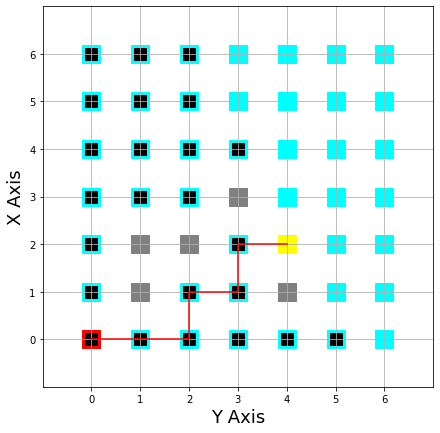

In [1]:
import queue
from typing import *
import typing
import numpy
import agent
import copy
from matplotlib import pyplot as plt

import os, psutil
import resource #erase

import environment 
import time

class Uniform_Cost_Search():
    def __init__(self):
        pass
    ###
    # find coordinate of a tile given its hash
    # 
    # input: 
    #   env: numpy matrix of 8 digit hash values
    #   hash_value: 8 digit hash of str(coordinate of tile)
    # output:
    #   [x,y] coordinates
    # 
    # ###     
    def find_tile_by_hash(self, env: environment.Environment, hash_value: int):
        x_coord, y_coord = numpy.where(env.get_environment_hash_matrix()[:,:] == hash_value)
        return [x_coord[0], y_coord[0]]


    ###
    # find list tiles accessible from current position (not obstacles)
    # update agent's moves possibilities
    # input:
    #       node_list_coord_hash: 8 digit hash of str(coordinate of tile)  
    #       env: numpy matrix of 8 digit hash values
    #       closed_set: seen nodes
    #       agent: current agent   
    # output:
    #       children_list: list of 8 digit hash values accessible from current position
    #       agent: updated agent
    ####   
    def generate_children_list(self, node_list_coord_hash: int, env: environment.Environment, closed_set: List[int] ,agent: agent.Agent):
        current_node_coord_list = self.find_tile_by_hash(env, node_list_coord_hash)
        node_x_axis = current_node_coord_list[0] 
        node_y_axis = current_node_coord_list[1]
        children_list = []
        moves_list = []#empty list
        agent_motion_cost = agent.get_motion_cost()

        ###### UPDATE AGENT MOVES POSSIBLITIES  
        #can agent go up ?
        if node_x_axis-1 >= 0:
            child_hash = env.get_environment_hash_matrix()[node_x_axis-1, node_y_axis]

            tile_is_obstacle = env.get_environment_matrix()[node_x_axis-1, node_y_axis]
            if(tile_is_obstacle == 0) and child_hash not in closed_set:#if tile is not obstacle
                children_list.append((agent_motion_cost[0] , child_hash))
                moves_list.append("U")
            pass

        # can agent go right ?
        if node_y_axis+1 < env.get_matrix_dimension()[1]:
            child_hash = env.get_environment_hash_matrix()[ node_x_axis, node_y_axis+1] 
            tile_is_obstacle = env.get_environment_matrix()[node_x_axis, node_y_axis+1]
            if(tile_is_obstacle == 0) and child_hash not in closed_set:#if tile is not obstacle
                children_list.append((agent_motion_cost[3] , child_hash))
                moves_list.append("R")
            pass   

        # can agent go down ?
        if node_x_axis+1 < env.get_matrix_dimension()[0]: 
            child_hash = env.get_environment_hash_matrix()[node_x_axis+1, node_y_axis]
            tile_is_obstacle = env.get_environment_matrix()[node_x_axis+1, node_y_axis]

            if(tile_is_obstacle == 0) and child_hash not in closed_set:#if tile is not obstacle
                children_list.append((agent_motion_cost[1] , child_hash))
                moves_list.append("D")
            pass
        
            # can agent go left ?
        if node_y_axis-1 >= 0:
            child_hash = env.get_environment_hash_matrix()[ node_x_axis, node_y_axis-1] 
            tile_is_obstacle = env.get_environment_matrix()[node_x_axis, node_y_axis-1]
            if(tile_is_obstacle == 0) and child_hash not in closed_set:#if tile is not obstacle
                children_list.append((agent_motion_cost[2] , child_hash))
                moves_list.append("L")
            pass

        agent.moves_list = moves_list # must return 

        return children_list, agent



    def fetch_Goal_Node(self, 
    intial_state: int, goal_state: int, env_matrix, agent: agent.Agent, my_plt):
        init_s_node_hash = intial_state
        goal_state_hash = goal_state
        edges_dict = {}
        memoized_costs = {}

        pop_side = 0 


        open_set = []#unexplored nodes (contains only hashes) sorted by node cost, with priority1 < priority_x < prioty_n
        open_set.append((0, init_s_node_hash))#populate first node
        

        closed_set = []
        memoized_costs[init_s_node_hash]=0#initial cost
        while open_set:

            open_set = sorted(open_set, key=lambda tup: tup[0]) #sort by cost

            parent = open_set[pop_side]

            if parent[1] == goal_state_hash:
                return (parent[1], edges_dict, memoized_costs)  

            open_set.remove(parent) #pop current (cost, state)  

            closed_set.append(parent[1])#and appends to seen nodes

            children_hash_list, updated_agent = self.generate_children_list(parent[1], env_matrix, closed_set , agent)

            motion_cost_set = updated_agent.get_motion_cost()

            parent_cost = memoized_costs[parent[1]]
            move_option = 0 #keep track of direction index of move in agent current move set

            #print explored node(expanded node)
            parent_coord = self.find_tile_by_hash(env_matrix, parent[1])
            my_plt.scatter(parent_coord[1], parent_coord[0], s=150, c='black', marker='s')

            #for every (motion_cost, child_hash) tuple
            for child_hash in children_hash_list:
                                 
                new_child = child_hash ##hash (state coorinate)
                child_hash_value = child_hash[1]

                current_child_cost = new_child[0]

                #if hash of new child not in closed set and (motion_cost, child_hash) not in open_set/frontier
                #len?
                if (child_hash_value not in closed_set)and (child_hash[1] not in [x[1] for x in open_set]): ##is child newly discovered? 

                        edges_dict[child_hash_value] = parent[1] #keep track of edges (ancestry) connections (new child tile) 

                        open_set_r, memoized_costs_r = self.update_frontier_memoize_child_cost(updated_agent, open_set, 
                        memoized_costs, new_child, motion_cost_set, move_option, parent_cost)
                        open_set = copy.deepcopy(open_set_r)
                        memoized_costs = copy.deepcopy(memoized_costs_r)
                    
                elif child_hash in open_set:

                    incumbent = memoized_costs[child_hash_value]

                    # cost of current child_hash < cost previous child
                    if current_child_cost < incumbent:
                        memoized_costs[child_hash_value] = current_child_cost #update cost of child from new parent
                        edges_dict[child_hash_value] = parent[1] #forget previous ancestor
                
                move_option = move_option+1           

        return (0, edges_dict, memoized_costs) #failed


    def update_frontier_memoize_child_cost(self, updated_agent, open_set, memoized_costs, child_hash, motion_cost_set, move_option, parent_cost):
        current_child_cost = 0                   
        move = updated_agent.get_moves_list()[move_option]
            
        if move == "U": 
            open_set.append((motion_cost_set[0]+parent_cost , child_hash[1]))##add on priority queue 
            memoized_costs[child_hash[1]] = motion_cost_set[0]+parent_cost #remember cost to that tile from current tile
        elif move == "D":    
            open_set.append((motion_cost_set[1]+parent_cost , child_hash[1]))##add on priority queue 
            memoized_costs[child_hash[1]] = motion_cost_set[1]+parent_cost #remember cost to that tile from current tile
        elif move == "L":
            open_set.append((motion_cost_set[2]+parent_cost , child_hash[1]))##add on priority queue
            memoized_costs[child_hash[1]] = motion_cost_set[2]+parent_cost #remember cost to that tile from current tile
        elif move == "R":    
            open_set.append((motion_cost_set[3]+parent_cost , child_hash[1]))##add on priority queue
            memoized_costs[child_hash[1]] = motion_cost_set[3]+parent_cost #remember cost to that tile from current tile

        return open_set, memoized_costs


    #reconstruct path from end to start
    def reconstruct_path(self, ancestors_dict, start_hash, goal_hash, env: environment.Environment):
        coord = self.find_tile_by_hash(env, goal_hash)
        current_key = goal_hash

        path_array = []
        path_array.append(coord)
        cost = 0
        print("VISITED POSITIONS ", len(ancestors_dict[1]))
        if(ancestors_dict[0]!= 0):#only reconstruct if we have found a path
            cost = cost+ancestors_dict[2][current_key]
            while current_key != start_hash:
                new_key = ancestors_dict[1][current_key]
                coord = self.find_tile_by_hash(env, new_key) 

                path_array.append(coord)
                current_key = new_key
                
        else:
            print("ancestry cannot be found path was not reached")
               
        return path_array[::-1], cost

start_time = time.time()
env = environment.Environment(7,7, [[1,1], [2,1], [2, 2], [3,3], [1,4]])

UCS = Uniform_Cost_Search()

agent = agent.Agent([0,0], [2,4], [1,2,3,4])

print("agent : start ", agent.initial_state, " agent goal ", agent.goal_state)

my_plt = env.draw_map(agent)
goal = UCS.fetch_Goal_Node(agent.get_initial_state_hash(), agent.get_goal_state_hash(), env, agent, my_plt)

process = psutil.Process(os.getpid())
print("memory usage ",process.memory_info().rss)  # in bytes 
print(" peak m usage ", resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print("total time ", time.time() - start_time)

print("------------- ROBOT SIMULATED PATH UCS GRAPH ------------------ ")
path = UCS.reconstruct_path(goal, agent.get_initial_state_hash(), agent.get_goal_state_hash(), env)
print(path[0],"\n cost = ",path[1])



x = [x[0] for x in  path[0]]
y = [x[1] for x in  path[0]]

my_plt.plot(y, x, linestyle='solid', c='red')

